In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import plotly.graph_objects as go
from torch.distributions import StudentT
import math

cond tensor shape: torch.Size([855, 10, 24])
cond dim: 240
target dim: 24
Total samples: 855, Training samples: 684, Validation samples: 171


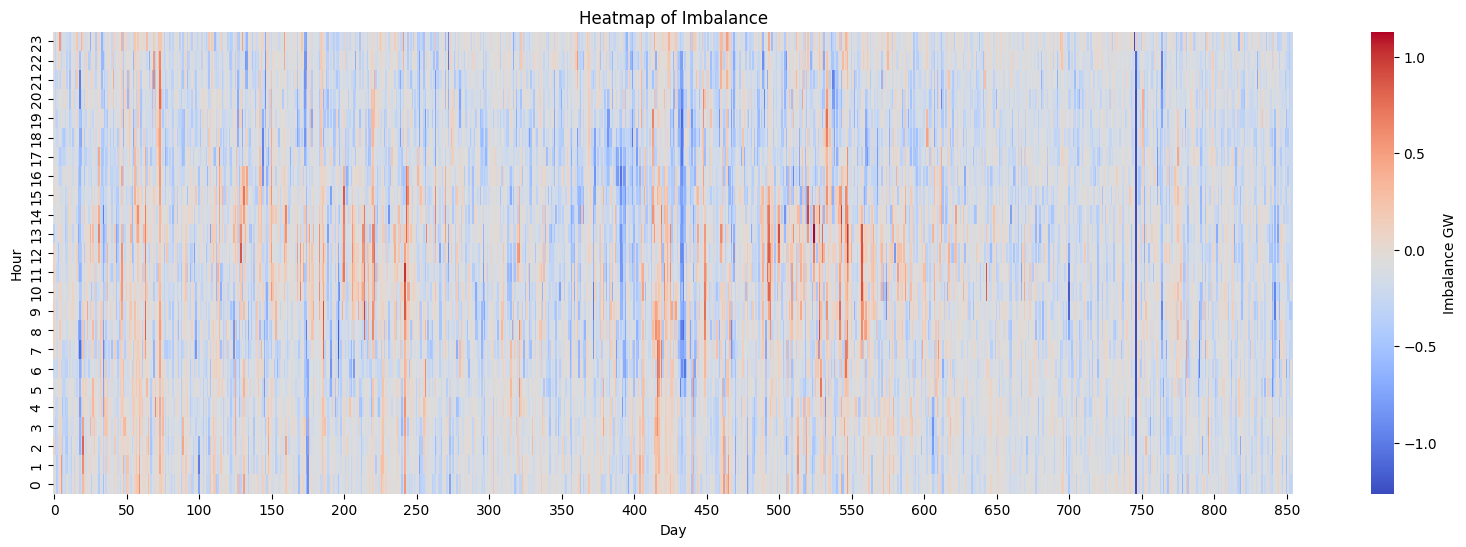

In [2]:
X = np.load("../data/X2.npy")
X = X[:855]
N, F, T = X.shape

target = X[:, 0, :]
condition = X[:, 1:, :]

for ch in [0, 1]:
    vals = condition[:, ch, :].reshape(-1, 1)
    mu = vals.mean()
    std = vals.std()
    condition[:, ch, :] = (condition[:, ch, :] - mu) / std

mask_bits = np.ones((N, 1, T), dtype=condition.dtype)
condition = np.concatenate([condition, mask_bits], axis=1)

cond_tensor = torch.tensor(condition, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(cond_tensor, target_tensor)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

cond_dim = condition.shape[1] * condition.shape[2]
target_dim = T
latent_dim = 32

print(f"cond tensor shape: {cond_tensor.shape}")
print(f"cond dim: {cond_dim}")
print(f"target dim: {target_dim}")
print(f"Total samples: {n_total}, Training samples: {n_train}, Validation samples: {n_val}")



plt.figure(figsize=(20, 6))
ax = sns.heatmap(target.T, cmap='coolwarm', cbar_kws={'label': 'Imbalance GW'}, xticklabels=50)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
plt.title("Heatmap of Imbalance")
plt.gca().invert_yaxis()
plt.show()


In [3]:
class MLPBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(MLPBlock, self).__init__()
        #inner_dim = 4 * input_dim 
        self.ln = nn.LayerNorm(input_dim)
        #self.fc1 = nn.Linear(input_dim, inner_dim)
        #self.fc2 = nn.Linear(inner_dim, input_dim)
        #self.relu = nn.ReLU()
        self.fc_in = nn.Linear(input_dim, 2 * hidden_dim)
        self.proj = nn.Linear(hidden_dim, input_dim)
        self.act = nn.GELU()

        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        #residual = x
        #x = self.layer_norm(x)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.dropout(x)
        #return x + residual
        h = self.ln(x)
        h2 = self.fc_in(h)
        val, gate = h2.chunk(2, dim=-1)
        h3 = val * torch.sigmoid(gate)
        h3 = self.act(h3)
        out = self.proj(h3)
        out = self.dropout(out)
        return out + x


In [4]:
class Encoder(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob):
        super(Encoder, self).__init__()
        input_dim = cond_dim + target_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, hidden_dim * 4, dropout_prob) for _ in range(mlp_blocks)])
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, cond, target):
        batch_size = cond.shape[0]
        cond_flat = cond.view(batch_size, -1)
        target_flat = target.view(batch_size, -1)

        x = torch.cat([cond_flat, target_flat], dim=1)
        x = self.input_layer(x)
        x = self.mlp(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

In [5]:
class Decoder(nn.Module):
    def __init__(self, cond_dim, latent_dim, target_dim, mlp_blocks, hidden_dim, dropout_prob):
        super(Decoder, self).__init__()
        self.fc_c = nn.Linear(cond_dim, hidden_dim)
        self.fc_z = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, hidden_dim * 4, dropout_prob) for _ in range(mlp_blocks)])
        self.out_mu     = nn.Linear(hidden_dim, target_dim)
        self.out_logvar = nn.Linear(hidden_dim, target_dim)
    
    def forward(self, cond, z):
        batch_size = cond.shape[0]
        cond_flat = cond.view(batch_size, -1)
        h_c = self.fc_c(cond_flat)
        h_z = self.fc_z(z)
        h = self.relu(h_c + h_z)
        h = self.mlp(h)
        mu_hat = self.out_mu(h)
        logvar_hat = self.out_logvar(h)
        return mu_hat, logvar_hat

In [6]:
class CVAE(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob):
        super(CVAE, self).__init__()
        self.encoder = Encoder(cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob)
        self.decoder = Decoder(cond_dim, latent_dim, target_dim, mlp_blocks, hidden_dim, dropout_prob)
        self.z_dropout = nn.Dropout(p=0.1)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, cond, target):
        mu, logvar = self.encoder(cond, target)   
        z = self.reparameterize(mu, logvar)
        mu_hat, logvar_hat = self.decoder(cond, z)
        
        return mu_hat, logvar_hat, mu, logvar

In [20]:
def pinball_loss(mu_hat, target, tau=0.95):
    delta = target - mu_hat
    loss = torch.maximum(tau * delta, (tau - 1) * delta)
    return loss.mean()


In [125]:
def crps_gaussian(mu, logvar, target):
    std = torch.exp(0.5 * logvar)
    diff = (target - mu) / std

    # standard normal PDF and CDF
    pdf = torch.exp(-0.5 * diff ** 2) / math.sqrt(2 * math.pi)
    cdf = 0.5 * (1 + torch.erf(diff / math.sqrt(2)))

    crps = std * (diff * (2 * cdf - 1) + 2 * pdf - 1 / math.sqrt(math.pi))
    return crps.mean()

In [7]:
def loss_function(mu_hat, logvar_hat, target, mu, logvar, kl_weight, min_kl=0.03, return_components=False):
    recon_nll = 0.5 * (logvar_hat + (target - mu_hat).pow(2).div(logvar_hat.exp())).mean()
    kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_per_dim = torch.clamp(kl_per_dim, min=min_kl)
    kl_loss = kl_per_dim.mean()

    total_loss = recon_nll + kl_weight * kl_loss

    if return_components:
        return total_loss, recon_nll, kl_loss
    return total_loss

In [8]:
final_beta = 0.1

def calculate_kl_weight(epoch, warmup_epochs, final_beta=final_beta):
    if epoch < warmup_epochs:
        return (epoch / warmup_epochs) * final_beta
    return final_beta

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(cond_dim, target_dim, latent_dim, mlp_blocks=4, hidden_dim=48, dropout_prob=0.4).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=5e-5)

In [10]:
num_epochs = 2000
warmup_epochs = int(0.10 * num_epochs)
mask_ratio = 0.2

# Lists to track metrics
train_losses = []
val_losses = []
kl_weights = []
recon_losses = []
kl_losses = []
weighted_kl_losses = []
masked_rmses = []

for epoch in range(num_epochs):
    kl_weight = calculate_kl_weight(epoch=epoch, warmup_epochs=warmup_epochs)
    kl_weights.append(kl_weight)
    
    model.train()
    train_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_kl_loss = 0.0
    epoch_weighted_kl_loss = 0.0
    epoch_masked_se = 0.0
    epoch_masked_count = 0
    
    for batch_cond, batch_target in train_loader:
        cond_orig = batch_cond.to(device)
        targ_orig = batch_target.to(device)
        cond = cond_orig.clone()
        targ = targ_orig.clone()

        noise_std = 0.1 
        cond = cond + torch.randn_like(cond) * noise_std
        targ = targ + torch.randn_like(targ) * (noise_std * 0.5)
        
        #mask = torch.ones_like(targ)
        #if torch.rand(1).item() < mask_ratio:
            #start = torch.randint(0, T, (1,)).item()
            #cond[:, :, start:] = 0.0
            #targ[:, start:] = 0.0
            #mask[:, start:] = 0.0

        
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        
        optimizer.zero_grad()
        mu_hat, logvar_hat, mu, logvar = model(cond, targ)
        loss, recon_nll, kl_term = loss_function(
            mu_hat, logvar_hat, batch_target, mu, logvar, kl_weight, return_components=True
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * batch_cond.size(0)
        epoch_recon_loss += recon_nll.item() * batch_cond.size(0)
        epoch_kl_loss += kl_term.item() * batch_cond.size(0)
        epoch_weighted_kl_loss += (kl_weight * kl_term.item()) * batch_cond.size(0)

        #with torch.no_grad():
            #se = ((mu_hat - targ_orig)**2 * (1 - mask)).sum().item()
            #cnt = (1 - mask).sum().item()
            #epoch_masked_se += se
            #epoch_masked_count += cnt
    
    #scheduler.step()
    
    # Average losses over the dataset
    avg_train_loss = train_loss / len(train_dataset)
    avg_recon_loss = epoch_recon_loss / len(train_dataset)
    avg_kl_loss = epoch_kl_loss / len(train_dataset)
    avg_weighted_kl_loss = epoch_weighted_kl_loss / len(train_dataset)
    
    train_losses.append(avg_train_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    weighted_kl_losses.append(avg_weighted_kl_loss)

    if epoch_masked_count > 0:
        masked_rmse = (epoch_masked_se / epoch_masked_count)**0.5
    else:
        masked_rmse = 0.0
    masked_rmses.append(masked_rmse)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_kl_loss = 0.0
    val_weighted_kl_loss = 0.0
    
    with torch.no_grad():
        for batch_cond, batch_target in val_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            mu_hat, logvar_hat, mu, logvar = model(batch_cond, batch_target)
            loss, recon_nll_val, kl_term_val = loss_function(
                mu_hat, logvar_hat, batch_target, mu, logvar, kl_weight, return_components=True
            )
            val_loss += loss.item() * batch_cond.size(0)
            val_recon_loss += recon_nll_val.item() * batch_cond.size(0)
            val_kl_loss += kl_term_val.item() * batch_cond.size(0)
            val_weighted_kl_loss += (kl_weight * kl_term_val.item()) * batch_cond.size(0)
    
    avg_val_loss = val_loss / len(val_dataset)
    avg_val_recon_loss = val_recon_loss / len(val_dataset)
    avg_val_kl_loss = val_kl_loss / len(val_dataset)
    avg_val_weighted_kl_loss = val_weighted_kl_loss / len(val_dataset)
    
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, KL Weight: {kl_weight:.4f}")
        print(f"Train Loss: {avg_train_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, Weighted KL: {avg_weighted_kl_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, Val KL Loss: {avg_val_kl_loss:.4f}, Val Weighted KL: {avg_val_weighted_kl_loss:.4f}")
        # print(f"Masked‐region RMSE: {masked_rmse:.4f}")

Epoch 1/2000, KL Weight: 0.0000
Train Loss: 0.0585, Recon Loss: 0.0585, KL Loss: 0.0800, Weighted KL: 0.0000
Val Loss: 0.0400, Val Recon Loss: 0.0400, Val KL Loss: 0.0773, Val Weighted KL: 0.0000
Epoch 100/2000, KL Weight: 0.0495
Train Loss: -1.1258, Recon Loss: -1.2341, KL Loss: 2.1879, Weighted KL: 0.1083
Val Loss: -1.1445, Val Recon Loss: -1.2514, Val KL Loss: 2.1602, Val Weighted KL: 0.1069
Epoch 200/2000, KL Weight: 0.0995
Train Loss: -1.2925, Recon Loss: -1.3889, KL Loss: 0.9692, Weighted KL: 0.0964
Val Loss: -1.2804, Val Recon Loss: -1.3746, Val KL Loss: 0.9467, Val Weighted KL: 0.0942
Epoch 300/2000, KL Weight: 0.1000
Train Loss: -1.4031, Recon Loss: -1.4881, KL Loss: 0.8498, Weighted KL: 0.0850
Val Loss: -1.3855, Val Recon Loss: -1.4693, Val KL Loss: 0.8378, Val Weighted KL: 0.0838
Epoch 400/2000, KL Weight: 0.1000
Train Loss: -1.4967, Recon Loss: -1.5838, KL Loss: 0.8711, Weighted KL: 0.0871
Val Loss: -1.4922, Val Recon Loss: -1.5775, Val KL Loss: 0.8534, Val Weighted KL: 0.0

In [ ]:
plt.plot(masked_rmses)
plt.xlabel("Epoch")
plt.ylabel("Masked RMSE")
plt.title("Imputation Error on Masked Regions Over Training")
plt.show()

In [ ]:
with torch.no_grad():
    total_kl = 0
    for cond, tar in val_loader:
       mu, logvar = model.encoder(cond.view(cond.size(0),-1), tar)
       kl = (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())).mean(dim=0)
       total_kl += kl
    avg_kl = total_kl / len(val_loader)
print(avg_kl.cpu().numpy())

In [ ]:
plt.figure(figsize=(16, 12))

# Plot 1: KL weight over time
plt.subplot(3, 2, 1)
plt.plot(kl_weights)
plt.xlabel('Epoch')
plt.ylabel('KL Weight')
plt.title('KL Annealing Schedule')
plt.grid(True)

# Plot 2: Total losses over time
plt.subplot(3, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss over Training')
plt.legend()
plt.grid(True)

# Plot 3: Reconstruction loss over time
plt.subplot(3, 2, 3)
plt.plot(recon_losses)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Training')
plt.grid(True)

# Plot 4: Raw KL divergence over time
plt.subplot(3, 2, 4)
plt.plot(kl_losses)
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('Raw KL Divergence (unweighted)')
plt.grid(True)

# Plot 5: Weighted KL divergence over time
plt.subplot(3, 2, 5)
plt.plot(weighted_kl_losses)
plt.xlabel('Epoch')
plt.ylabel('Weighted KL Loss')
plt.title('Weighted KL Divergence')
plt.grid(True)

# Plot 6: Ratio of KL to reconstruction loss
plt.subplot(3, 2, 6)
ratio = [kl/recon if recon > 0 else 0 for kl, recon in zip(kl_losses, recon_losses)]
plt.plot(ratio)
plt.xlabel('Epoch')
plt.ylabel('KL / Reconstruction Ratio')
plt.title('Ratio of KL Divergence to Reconstruction Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
def get_doy_and_dow_from_validation(val_dataset, val_index):
    sample_cond, sample_target = val_dataset[val_index]
    target_numpy = sample_target.numpy()

    day_sin = sample_cond[5, 0].item()
    day_cos = sample_cond[6, 0].item()
    week_sin = sample_cond[7, 0].item()
    week_cos = sample_cond[8, 0].item()

    day_rad = np.arctan2(day_sin, day_cos)
    day_angle = day_rad if day_rad >= 0 else day_rad + (2 * np.pi)
    day_of_year_float = (day_angle / (2 * np.pi)) * 365.25
    day_of_year = int(np.clip(round(day_of_year_float), 1, 365))

    week_rad = np.arctan2(week_sin, week_cos)
    week_angle = week_rad if week_rad >= 0 else week_rad + (2 * np.pi)
    day_of_week_float = (week_angle / (2 * np.pi)) * 7.0
    day_of_week = int(round(day_of_week_float) % 7)

    return day_of_year, day_of_week, target_numpy

In [12]:
def find_week_earlier_target_with_dow(current_doy, current_dow, X):
    target_dow = current_dow % 7
    target_doy = (current_doy - 1 - 7) % 365 + 1

    all_week_sin, all_week_cos = X[:, 7, 0], X[:, 8, 0]
    all_week_rad = np.arctan2(all_week_sin, all_week_cos)
    all_week_angle = np.where(all_week_rad >= 0, all_week_rad, all_week_rad + (2 * np.pi))
    all_calculated_dow = np.round((all_week_angle / (2 * np.pi)) * 7.0).astype(int) % 7

    dow_match_indices = np.where(all_calculated_dow == target_dow)[0]
    if len(dow_match_indices) == 0: return None

    subset_day_sin = X[dow_match_indices, 5, 0]
    subset_day_cos = X[dow_match_indices, 6, 0]
    subset_day_rad = np.arctan2(subset_day_sin, subset_day_cos)
    subset_day_angle = np.where(subset_day_rad >= 0, subset_day_rad, subset_day_rad + (2 * np.pi))
    subset_doy_float = (subset_day_angle / (2 * np.pi)) * 365.25
    subset_calculated_doy = np.clip(np.round(subset_doy_float), 1, 365).astype(int)

    diff = np.abs(subset_calculated_doy - target_doy)
    min_diff = np.minimum(diff, 365 - diff)
    best_subset_idx = np.argmin(min_diff)
    original_idx = dow_match_indices[best_subset_idx]

    return X[original_idx, 0, :]

In [13]:
def get_seven_days_before_target(target_output, X):
    all_targets = X[:, 0, :]

    matches = []
    for i in range(len(all_targets)):
        if np.allclose(all_targets[i], target_output, rtol=1e-5, atol=1e-5):
            matches.append(i)
    
    if not matches:
        print("Target not found in dataset X")
        return None
    
    target_idx = matches[0]

    if target_idx < 7:
        print(f"Not enough days before target (index: {target_idx})")
        return None
    
    seven_days_before = all_targets[target_idx-7:target_idx]
    return seven_days_before

In [14]:
def evaluate_directional_improvement(target_data, prediction_data, positive=True, label="Prediction"):
    mask = target_data > 0 if positive else target_data < 0
    direction = "positive" if positive else "negative"
    
    filtered_indices = np.where(mask)[0]
    filtered_target = target_data[mask]
    
    if len(filtered_target) == 0:
        print(f"  No {direction} values found in target data.")
        return False
    
    filtered_prediction = prediction_data[filtered_indices]
    
    if positive:
        comparison_count = np.sum(filtered_target > filtered_prediction)
        comparison_text = "Target > Prediction"
    else:
        comparison_count = np.sum(filtered_target < filtered_prediction)
        comparison_text = "Target < Prediction"
    
    total_points = len(filtered_target)
    percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
    abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
    
    print(f"  {direction.capitalize()} Values Metrics for {label}:")
    print(f"    {comparison_text}: {percentage:.2f}% ({comparison_count}/{total_points})")
    print(f"    Avg Absolute Diff: {abs_diff:.4f}")
    
    return True

In [35]:
def plot_val_with_std_band(model, X, val_dataset, latent_dim, val_index, num_samples=10000):
    _, _, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
    seven_days_before = get_seven_days_before_target(target_data, X)
    if seven_days_before is None: return None
    
    past_mean = np.mean(seven_days_before, axis=0)
    past_std = np.std(seven_days_before, axis=0)
    
    max_imbalance = np.max(X[:, 0, :])
    min_imbalance = np.min(X[:, 0, :])
    max_line_data = np.full(target_data.shape[0], max_imbalance)
    min_line_data = np.full(target_data.shape[0], min_imbalance)
    
    sample_cond, _ = val_dataset[val_index]
    cond_flat = sample_cond.unsqueeze(0).to(device).view(1, -1)
    cond_batch = sample_cond.unsqueeze(0).to(device)

    samples_list = []
    model.eval()
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            mu_hat, logvar_hat = model.decoder(cond_flat, z)
            eps = torch.randn_like(logvar_hat)
            recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
            samples_list.append(recon.cpu().numpy().flatten())

    samples_array = np.array(samples_list)
    percentile_95 = np.percentile(samples_array, 95, axis=0)
    percentile_5 = np.percentile(samples_array, 5, axis=0)

    print(f"--- Evaluation for Val Idx {val_index} ---")
    evaluate_directional_improvement(target_data, percentile_95, positive=True, label="95th Percentile")
    print("-" * 20)
    evaluate_directional_improvement(target_data, percentile_5, positive=False, label="5th Percentile")
    print("-" * 20)
    evaluate_directional_improvement(target_data, max_line_data, positive=True, label="Max Value in X")
    print("-" * 20)
    evaluate_directional_improvement(target_data, min_line_data, positive=False, label="Min Value in X")
    print("-" * 20)
    
    hours = list(range(24))
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=hours, y=target_data, name="Target", line=dict(color='black', width=2)))
    fig.add_trace(go.Scatter(x=hours, y=min_line_data, name="Overall Min", line=dict(color='grey', width=2, dash='dash')))
    fig.add_trace(go.Scatter(x=hours, y=max_line_data, name="Overall Max", line=dict(color='grey', width=2, dash='dash')))
    fig.add_trace(go.Scatter(x=hours, y=percentile_95, name="95th Percentile", line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=hours, y=percentile_5, name="5th Percentile", line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=hours, y=past_mean, name="Mean of Past 7 Days", line=dict(color='red', width=2)))
    
    fig.add_trace(go.Scatter(
        x=hours + hours[::-1],
        y=np.concatenate([past_mean + 2*past_std, (past_mean - 2*past_std)[::-1]]),
        fill='toself',
        fillcolor='rgba(255,0,0,0.1)',
        line=dict(color='rgba(255,0,0,0)'),
        name='Mean + 2*StdDev'
    ))
    
    fig.update_layout(title=f"Val Idx {val_index}", xaxis_title="Hour", yaxis_title="Value")
    return fig

In [ ]:
fig = plot_val_with_std_band(model, X, val_dataset, latent_dim, 4, 1000)
if fig: fig.show()

In [15]:
def calculate_average_metrics(model, X, val_dataset, latent_dim, num_samples=10000):
    metrics = {
        "95th_percentile": {"positive": {"percentage": [], "abs_diff": []}, "count": 0},
        "5th_percentile": {"negative": {"percentage": [], "abs_diff": []}, "count": 0},
        "past_mean_plus_2std": {"positive": {"percentage": [], "abs_diff": []}, "count": 0},
        "past_mean_minus_2std": {"negative": {"percentage": [], "abs_diff": []}, "count": 0},
        "max_value": {"positive": {"percentage": [], "abs_diff": []}, "count": 0},
        "min_value": {"negative": {"percentage": [], "abs_diff": []}, "count": 0}
    }
    
    samples_processed = 0
    
    for val_index in range(len(val_dataset)):
        _, _, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
        seven_days_before = get_seven_days_before_target(target_data, X)
        if seven_days_before is None: continue
        
        past_mean = np.mean(seven_days_before, axis=0)
        past_std = np.std(seven_days_before, axis=0)
        
        past_mean_plus_2std = past_mean + 2*past_std
        past_mean_minus_2std = past_mean - 2*past_std
        
        max_imbalance = np.max(X[:, 0, :])
        min_imbalance = np.min(X[:, 0, :])
        max_line_data = np.full(target_data.shape[0], max_imbalance)
        min_line_data = np.full(target_data.shape[0], min_imbalance)
        
        sample_cond, _ = val_dataset[val_index]
        cond_flat = sample_cond.unsqueeze(0).to(device).view(1, -1)
        cond_batch = sample_cond.unsqueeze(0).to(device)

        samples_list = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_samples):
                z = torch.randn(1, latent_dim).to(device)
                mu_hat, logvar_hat = model.decoder(cond_flat, z)
                eps = torch.randn_like(logvar_hat)
                recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
                samples_list.append(recon.cpu().numpy().flatten())
                #mu_hat, log_scale_hat, df = model.decoder(cond_batch, z)
                #scale = torch.exp(log_scale_hat)
                #dist  = StudentT(df, loc=mu_hat, scale=scale)
                #recon = dist.sample()
                #samples_list.append(recon.cpu().numpy().flatten())

        samples_array = np.array(samples_list)
        percentile_95 = np.percentile(samples_array, 95, axis=0)
        percentile_5 = np.percentile(samples_array, 5, axis=0)

        # Collect metrics
        # 95th percentile (positive values)
        mask_positive = target_data > 0
        if np.any(mask_positive):
            filtered_indices = np.where(mask_positive)[0]
            filtered_target = target_data[mask_positive]
            filtered_prediction = percentile_95[filtered_indices]
            
            comparison_count = np.sum(filtered_target > filtered_prediction)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            metrics["95th_percentile"]["positive"]["percentage"].append(percentage)
            metrics["95th_percentile"]["positive"]["abs_diff"].append(abs_diff)
            metrics["95th_percentile"]["count"] += 1
        
        # 5th percentile (negative values)
        mask_negative = target_data < 0
        if np.any(mask_negative):
            filtered_indices = np.where(mask_negative)[0]
            filtered_target = target_data[mask_negative]
            filtered_prediction = percentile_5[filtered_indices]
            
            comparison_count = np.sum(filtered_target < filtered_prediction)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            metrics["5th_percentile"]["negative"]["percentage"].append(percentage)
            metrics["5th_percentile"]["negative"]["abs_diff"].append(abs_diff)
            metrics["5th_percentile"]["count"] += 1
        
        # Max value (positive values)
        if np.any(mask_positive):
            filtered_indices = np.where(mask_positive)[0]
            filtered_target = target_data[mask_positive]
            filtered_prediction = max_line_data[filtered_indices]

            tolerance = 1e-7
            comparison_count = np.sum(filtered_target - filtered_prediction > tolerance)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            metrics["max_value"]["positive"]["percentage"].append(percentage)
            metrics["max_value"]["positive"]["abs_diff"].append(abs_diff)
            metrics["max_value"]["count"] += 1
        
        # Min value (negative values)
        if np.any(mask_negative):
            filtered_indices = np.where(mask_negative)[0]
            filtered_target = target_data[mask_negative]
            filtered_prediction = min_line_data[filtered_indices]
            
            tolerance = 1e-7
            comparison_count = np.sum(filtered_target - filtered_prediction < -tolerance)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            metrics["min_value"]["negative"]["percentage"].append(percentage)
            metrics["min_value"]["negative"]["abs_diff"].append(abs_diff)
            metrics["min_value"]["count"] += 1
            
        # Past mean + 2*std (positive values)
        if np.any(mask_positive):
            filtered_indices = np.where(mask_positive)[0]
            filtered_target = target_data[mask_positive]
            filtered_prediction = past_mean_plus_2std[filtered_indices]
            
            comparison_count = np.sum(filtered_target > filtered_prediction)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            metrics["past_mean_plus_2std"]["positive"]["percentage"].append(percentage)
            metrics["past_mean_plus_2std"]["positive"]["abs_diff"].append(abs_diff)
            metrics["past_mean_plus_2std"]["count"] += 1
            
        # Past mean - 2*std (negative values)
        if np.any(mask_negative):
            filtered_indices = np.where(mask_negative)[0]
            filtered_target = target_data[mask_negative]
            filtered_prediction = past_mean_minus_2std[filtered_indices]
            
            comparison_count = np.sum(filtered_target < filtered_prediction)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            metrics["past_mean_minus_2std"]["negative"]["percentage"].append(percentage)
            metrics["past_mean_minus_2std"]["negative"]["abs_diff"].append(abs_diff)
            metrics["past_mean_minus_2std"]["count"] += 1
        
        samples_processed += 1
    
    # Calculate averages
    results = {}
    
    for metric_name, metric_data in metrics.items():
        if "positive" in metric_data:
            if metric_data["count"] > 0:
                avg_percentage = np.mean(metric_data["positive"]["percentage"])
                avg_abs_diff = np.mean(metric_data["positive"]["abs_diff"])
                results[f"{metric_name}_positive_percentage"] = avg_percentage
                results[f"{metric_name}_positive_abs_diff"] = avg_abs_diff
        
        if "negative" in metric_data:
            if metric_data["count"] > 0:
                avg_percentage = np.mean(metric_data["negative"]["percentage"])
                avg_abs_diff = np.mean(metric_data["negative"]["abs_diff"])
                results[f"{metric_name}_negative_percentage"] = avg_percentage
                results[f"{metric_name}_negative_abs_diff"] = avg_abs_diff
    
    results["samples_processed"] = samples_processed
    
    print(f"Processed {samples_processed} validation samples")
    print("\nAverage Metrics:")
    for key, value in results.items():
        if key != "samples_processed":
            print(f"  {key}: {value:.2f}")
    
    return results

In [ ]:
results = calculate_average_metrics(model, X, val_dataset, latent_dim, 500)

In [97]:
def plot_val_with_masked_hours(model, val_dataset, latent_dim, val_index, keep_hour=None, num_samples=10000):
    _, _, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
    if target_data is None: return None
    
    sample_cond, _ = val_dataset[val_index]
    masked_cond = sample_cond.clone()
    
    if keep_hour is not None and 0 <= keep_hour < masked_cond.shape[1]:
        for hour_idx in range(masked_cond.shape[1]):
            if hour_idx > keep_hour:
                masked_cond[:, hour_idx] = 0.0
    
    cond_flat = masked_cond.unsqueeze(0).to(device).view(1, -1)
    
    samples_list = []
    model.eval()
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            mu_hat, logvar_hat = model.decoder(cond_flat, z)
            eps = torch.randn_like(logvar_hat)
            recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
            samples_list.append(recon.cpu().numpy().flatten())
    
    samples_array = np.array(samples_list)
    percentile_95 = np.percentile(samples_array, 95, axis=0)
    percentile_5 = np.percentile(samples_array, 5, axis=0)
    
    # Print evaluation results
    print(f"--- Evaluation for Val Idx {val_index} with Hour Masking ---")
    evaluate_directional_improvement(target_data, percentile_95, positive=True, label="95th Percentile")
    print("-" * 20)
    evaluate_directional_improvement(target_data, percentile_5, positive=False, label="5th Percentile")
    
    hours = list(range(24))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hours, y=target_data, name="Target", line=dict(color='black', width=2)))
    fig.add_trace(go.Scatter(x=hours, y=percentile_95, name="95th Percentile", line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=hours, y=percentile_5, name="5th Percentile", line=dict(color='blue', width=2)))
    
    # Update layout
    mask_str = f", Up to hour {keep_hour+1} Kept"
    fig.update_layout(
        title=f"Val Idx {val_index}{mask_str}", 
        xaxis_title="Hour", 
        yaxis_title="Value"
    )
    
    return fig

In [ ]:
plot_val_with_masked_hours(model, val_dataset, latent_dim, val_index=1, keep_hour=24, num_samples=100)

In [16]:
def calculate_percentile_metrics_with_hourly_graph(model, X, val_dataset, latent_dim, num_samples=10000):
    metrics = {
        "95th_percentile": {"positive": {"percentage": [], "abs_diff": [], "hour_errors": [[] for _ in range(24)]}, "count": 0},
        "5th_percentile": {"negative": {"percentage": [], "abs_diff": [], "hour_errors": [[] for _ in range(24)]}, "count": 0}
    }
    
    samples_processed = 0
    
    for val_index in range(len(val_dataset)):
        doy, dow, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
        seven_days_before = get_seven_days_before_target(target_data, X)
        if seven_days_before is None: continue
        
        sample_cond, _ = val_dataset[val_index]
        cond_flat = sample_cond.unsqueeze(0).to(device).view(1, -1)

        samples_list = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_samples):
                z = torch.randn(1, latent_dim).to(device)
                mu_hat, logvar_hat = model.decoder(cond_flat, z)
                eps = torch.randn_like(logvar_hat)
                recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
                samples_list.append(recon.cpu().numpy().flatten())

        samples_array = np.array(samples_list)
        percentile_95 = np.percentile(samples_array, 95, axis=0)
        percentile_5 = np.percentile(samples_array, 5, axis=0)

        mask_positive = target_data > 0
        if np.any(mask_positive):
            filtered_indices = np.where(mask_positive)[0]
            filtered_target = target_data[mask_positive]
            filtered_prediction = percentile_95[filtered_indices]
            
            comparison_count = np.sum(filtered_target > filtered_prediction)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            for i, idx in enumerate(filtered_indices):
                hour = idx % 24
                error = abs(filtered_target[i] - filtered_prediction[i])
                metrics["95th_percentile"]["positive"]["hour_errors"][hour].append(error)
            
            metrics["95th_percentile"]["positive"]["percentage"].append(percentage)
            metrics["95th_percentile"]["positive"]["abs_diff"].append(abs_diff)
            metrics["95th_percentile"]["count"] += 1
        
        mask_negative = target_data < 0
        if np.any(mask_negative):
            filtered_indices = np.where(mask_negative)[0]
            filtered_target = target_data[mask_negative]
            filtered_prediction = percentile_5[filtered_indices]
            
            comparison_count = np.sum(filtered_target < filtered_prediction)
            total_points = len(filtered_target)
            percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
            abs_diff = np.mean(np.abs(filtered_target - filtered_prediction))
            
            for i, idx in enumerate(filtered_indices):
                hour = idx % 24
                error = abs(filtered_target[i] - filtered_prediction[i])
                metrics["5th_percentile"]["negative"]["hour_errors"][hour].append(error)
            
            metrics["5th_percentile"]["negative"]["percentage"].append(percentage)
            metrics["5th_percentile"]["negative"]["abs_diff"].append(abs_diff)
            metrics["5th_percentile"]["count"] += 1
        
        samples_processed += 1
    
    results = {}
    
    for metric_name, metric_data in metrics.items():
        if "positive" in metric_data and metric_data["count"] > 0:
            results[f"{metric_name}_positive_percentage"] = np.mean(metric_data["positive"]["percentage"])
            results[f"{metric_name}_positive_abs_diff"] = np.mean(metric_data["positive"]["abs_diff"])
        
        if "negative" in metric_data and metric_data["count"] > 0:
            results[f"{metric_name}_negative_percentage"] = np.mean(metric_data["negative"]["percentage"])
            results[f"{metric_name}_negative_abs_diff"] = np.mean(metric_data["negative"]["abs_diff"])
    
    results["samples_processed"] = samples_processed
    
    print(f"Processed {samples_processed} validation samples")
    print("\nAverage Metrics:")
    for key, value in results.items():
        if key != "samples_processed":
            print(f"  {key}: {value:.2f}")
    
    hourly_data = {"95th_percentile_positive": [], "5th_percentile_negative": []}
    
    for hour in range(24):
        hourly_data["95th_percentile_positive"].append(np.mean(metrics["95th_percentile"]["positive"]["hour_errors"][hour]) if metrics["95th_percentile"]["positive"]["hour_errors"][hour] else 0)
        hourly_data["5th_percentile_negative"].append(np.mean(metrics["5th_percentile"]["negative"]["hour_errors"][hour]) if metrics["5th_percentile"]["negative"]["hour_errors"][hour] else 0)
    
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(range(24), hourly_data["95th_percentile_positive"], 'o-', color='red', linewidth=2, markersize=8)
    plt.title('95th Percentile (Positive Values) - Mean Absolute Error by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Mean Absolute Error')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(24))
    
    plt.subplot(2, 1, 2)
    plt.plot(range(24), hourly_data["5th_percentile_negative"], 'o-', color='blue', linewidth=2, markersize=8)
    plt.title('5th Percentile (Negative Values) - Mean Absolute Error by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Mean Absolute Error')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(24))
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 8))
    
    x = np.arange(24)
    width = 0.35
    
    plt.bar(x - width/2, hourly_data["95th_percentile_positive"], width, label='95th Percentile (Positive)', color='red', alpha=0.7)
    plt.bar(x + width/2, hourly_data["5th_percentile_negative"], width, label='5th Percentile (Negative)', color='blue', alpha=0.7)
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Mean Absolute Error')
    plt.title('Comparison of 5th and 95th Percentile Errors by Hour')
    plt.xticks(range(24))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    sample_counts = {
        "positive_samples_per_hour": [len(metrics["95th_percentile"]["positive"]["hour_errors"][h]) for h in range(24)],
        "negative_samples_per_hour": [len(metrics["5th_percentile"]["negative"]["hour_errors"][h]) for h in range(24)]
    }
    
    plt.figure(figsize=(15, 6))
    plt.bar(x - width/2, sample_counts["positive_samples_per_hour"], width, label='Positive Samples', color='darkred', alpha=0.7)
    plt.bar(x + width/2, sample_counts["negative_samples_per_hour"], width, label='Negative Samples', color='darkblue', alpha=0.7)
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Samples')
    plt.title('Sample Distribution by Hour')
    plt.xticks(range(24))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return results, hourly_data, sample_counts

In [ ]:
results, hourly_data, sample_counts = calculate_percentile_metrics_with_hourly_graph(model, X, val_dataset, latent_dim, 500)

In [32]:
def calculate_seasonal_hourly_metrics(model, X, val_dataset, latent_dim, num_samples=10000):
    month_hour_errors = {"95th_percentile": np.zeros((12, 24)), "5th_percentile": np.zeros((12, 24))}
    month_hour_counts = {"95th_percentile": np.zeros((12, 24)), "5th_percentile": np.zeros((12, 24))}
    
    for val_index in range(len(val_dataset)):
        doy, dow, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
        seven_days_before = get_seven_days_before_target(target_data, X)
        if seven_days_before is None: continue
        
        month = (doy // 30) % 12
        if month == 0: month = 11 if doy > 330 else 0
        
        sample_cond, _ = val_dataset[val_index]
        cond_flat = sample_cond.unsqueeze(0).to(device).view(1, -1)

        samples_list = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_samples):
                z = torch.randn(1, latent_dim).to(device)
                mu_hat, logvar_hat = model.decoder(cond_flat, z)
                eps = torch.randn_like(logvar_hat)
                recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
                samples_list.append(recon.cpu().numpy().flatten())

        samples_array = np.array(samples_list)
        percentile_95 = np.percentile(samples_array, 95, axis=0)
        percentile_5 = np.percentile(samples_array, 5, axis=0)

        mask_positive = target_data > 0
        if np.any(mask_positive):
            filtered_indices = np.where(mask_positive)[0]
            filtered_target = target_data[mask_positive]
            filtered_prediction = percentile_95[filtered_indices]
            
            for i, idx in enumerate(filtered_indices):
                hour = idx % 24
                error = abs(filtered_target[i] - filtered_prediction[i])
                month_hour_errors["95th_percentile"][month, hour] += error
                month_hour_counts["95th_percentile"][month, hour] += 1
        
        mask_negative = target_data < 0
        if np.any(mask_negative):
            filtered_indices = np.where(mask_negative)[0]
            filtered_target = target_data[mask_negative]
            filtered_prediction = percentile_5[filtered_indices]
            
            for i, idx in enumerate(filtered_indices):
                hour = idx % 24
                error = abs(filtered_target[i] - filtered_prediction[i])
                month_hour_errors["5th_percentile"][month, hour] += error
                month_hour_counts["5th_percentile"][month, hour] += 1
    
    season_mapping = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 3, 11: 0}
    season_names = ['Winter', 'Spring', 'Summer', 'Fall']
    
    season_hour_errors = {"95th_percentile": np.zeros((4, 24)), "5th_percentile": np.zeros((4, 24))}
    season_hour_counts = {"95th_percentile": np.zeros((4, 24)), "5th_percentile": np.zeros((4, 24))}
    
    for metric in ["95th_percentile", "5th_percentile"]:
        for m in range(12):
            season = season_mapping[m]
            for h in range(24):
                season_hour_errors[metric][season, h] += month_hour_errors[metric][m, h]
                season_hour_counts[metric][season, h] += month_hour_counts[metric][m, h]
    
    avg_season_hour_errors = {"95th_percentile": np.zeros((4, 24)), "5th_percentile": np.zeros((4, 24))}
    
    for metric in ["95th_percentile", "5th_percentile"]:
        for s in range(4):
            for h in range(24):
                if season_hour_counts[metric][s, h] > 0:
                    avg_season_hour_errors[metric][s, h] = season_hour_errors[metric][s, h] / season_hour_counts[metric][s, h]
    
    
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    sns.heatmap(avg_season_hour_errors["95th_percentile"], cmap="YlOrRd", xticklabels=range(24), yticklabels=season_names, cbar_kws={'label': 'Mean Absolute Error'})
    plt.title('95th Percentile - Season-Hour Error')
    plt.xlabel('Hour of Day')
    plt.ylabel('Season')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(avg_season_hour_errors["5th_percentile"], cmap="YlOrRd", xticklabels=range(24), yticklabels=season_names, cbar_kws={'label': 'Mean Absolute Error'})
    plt.title('5th Percentile - Season-Hour Error')
    plt.xlabel('Hour of Day')
    plt.ylabel('Season')
    
    plt.tight_layout()
    plt.show()
    
    return {"season_hour_errors": avg_season_hour_errors, "season_hour_counts": season_hour_counts}

In [ ]:
calculate_seasonal_hourly_metrics(model, X, val_dataset, latent_dim, 500)

In [52]:
def plot_percentile_accuracy(model, X, val_dataset, latent_dim, num_samples=5000):
    pos_percentiles = [97.5, 95, 92.5, 90, 87.5, 85, 82.5, 80, 77.5, 75]
    neg_percentiles = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]
    
    pos_results = {p: [] for p in pos_percentiles}
    neg_results = {p: [] for p in neg_percentiles}
    
    for val_index in range(len(val_dataset)):
        _, _, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
        if target_data is None or len(target_data) == 0: continue
            
        sample_cond, _ = val_dataset[val_index]
        cond_flat = sample_cond.unsqueeze(0).to(device).view(1, -1)
        
        samples_list = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_samples):
                z = torch.randn(1, latent_dim).to(device)
                mu_hat, logvar_hat = model.decoder(cond_flat, z)
                eps = torch.randn_like(logvar_hat)
                recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
                samples_list.append(recon.cpu().numpy().flatten())
        
        samples_array = np.array(samples_list)
        mask_positive = target_data > 0
        mask_negative = target_data < 0
        
        # Process positive percentiles
        if np.any(mask_positive):
            for p in pos_percentiles:
                percentile_pred = np.percentile(samples_array, p, axis=0)
                filtered_indices = np.where(mask_positive)[0]
                filtered_target = target_data[mask_positive]
                filtered_prediction = percentile_pred[filtered_indices]
                
                comparison_count = np.sum(filtered_target > filtered_prediction)
                total_points = len(filtered_target)
                percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
                pos_results[p].append(percentage)
        
        # Process negative percentiles
        if np.any(mask_negative):
            for p in neg_percentiles:
                percentile_pred = np.percentile(samples_array, p, axis=0)
                filtered_indices = np.where(mask_negative)[0]
                filtered_target = target_data[mask_negative]
                filtered_prediction = percentile_pred[filtered_indices]
                
                comparison_count = np.sum(filtered_target < filtered_prediction)
                total_points = len(filtered_target)
                percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
                neg_results[p].append(percentage)
    
    # Calculate averages
    pos_avgs = [np.mean(pos_results[p]) if pos_results[p] else 0 for p in pos_percentiles]
    neg_avgs = [np.mean(neg_results[p]) if neg_results[p] else 0 for p in neg_percentiles]
    
    # Create plots as line charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    
    # Positive values plot
    ax1.plot(pos_avgs, pos_percentiles, 'bo-', markersize=8)
    ax1.set_ylabel('Percentile')
    ax1.set_xlabel('% cases where Target > Prediction')
    ax1.set_title('Positive Values: Percentile vs Target Exceeding Prediction')
    ax1.grid(True)
    
    # Add percentage values next to each point
    for i, v in enumerate(pos_avgs):
        ax1.text(v + 1, pos_percentiles[i], f'{v:.1f}%', va='center')
    
    # Negative values plot
    ax2.plot(neg_avgs, neg_percentiles, 'ro-', markersize=8)
    ax2.set_ylabel('Percentile')
    ax2.set_xlabel('% cases where Target < Prediction')
    ax2.set_title('Negative Values: Percentile vs Target Below Prediction')
    ax2.grid(True)
    
    # Add percentage values next to each point
    for i, v in enumerate(neg_avgs):
        ax2.text(v + 1, neg_percentiles[i], f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'pos_percentiles': pos_percentiles,
        'pos_percentages': pos_avgs,
        'neg_percentiles': neg_percentiles,
        'neg_percentages': neg_avgs
    }

In [ ]:
plot_percentile_accuracy(model, X, val_dataset, latent_dim, 500)

In [17]:
def plot_masking_impact(model, val_dataset, latent_dim, num_samples=5000):
    hours_to_keep = list(range(0, 24))
    positive_accuracy = {h: [] for h in hours_to_keep}
    negative_accuracy = {h: [] for h in hours_to_keep}
    positive_mae = {h: [] for h in hours_to_keep}
    negative_mae = {h: [] for h in hours_to_keep}
    
    for val_index in range(len(val_dataset)):
        _, _, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
        if target_data is None: continue
        
        sample_cond, _ = val_dataset[val_index]
        
        for keep_hour in hours_to_keep:
            masked_cond = sample_cond.clone()
            for hour_idx in range(masked_cond.shape[1]):
                if hour_idx > keep_hour:
                    masked_cond[:, hour_idx] = 0.0
            
            cond_flat = masked_cond.unsqueeze(0).to(device).view(1, -1)
            
            samples_list = []
            model.eval()
            with torch.no_grad():
                for _ in range(num_samples):
                    z = torch.randn(1, latent_dim).to(device)
                    mu_hat, logvar_hat = model.decoder(cond_flat, z)
                    eps = torch.randn_like(logvar_hat)
                    recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
                    samples_list.append(recon.cpu().numpy().flatten())
            
            samples_array = np.array(samples_list)
            percentile_95 = np.percentile(samples_array, 95, axis=0)
            percentile_5 = np.percentile(samples_array, 5, axis=0)
            
            mask_positive = target_data > 0
            mask_negative = target_data < 0
            
            if np.any(mask_positive):
                filtered_indices = np.where(mask_positive)[0]
                filtered_target = target_data[mask_positive]
                filtered_p95 = percentile_95[filtered_indices]
                
                comparison_count = np.sum(filtered_target > filtered_p95)
                total_points = len(filtered_target)
                percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
                positive_accuracy[keep_hour].append(percentage)
                
                mae = np.mean(np.abs(filtered_target - filtered_p95))
                positive_mae[keep_hour].append(mae)
            
            if np.any(mask_negative):
                filtered_indices = np.where(mask_negative)[0]
                filtered_target = target_data[mask_negative]
                filtered_p5 = percentile_5[filtered_indices]
                
                comparison_count = np.sum(filtered_target < filtered_p5)
                total_points = len(filtered_target)
                percentage = (comparison_count / total_points * 100) if total_points > 0 else 0
                negative_accuracy[keep_hour].append(percentage)
                
                mae = np.mean(np.abs(filtered_target - filtered_p5))
                negative_mae[keep_hour].append(mae)
    
    pos_acc_avg = [np.mean(positive_accuracy[h]) if positive_accuracy[h] else np.nan for h in hours_to_keep]
    neg_acc_avg = [np.mean(negative_accuracy[h]) if negative_accuracy[h] else np.nan for h in hours_to_keep]
    pos_mae_avg = [np.mean(positive_mae[h]) if positive_mae[h] else np.nan for h in hours_to_keep]
    neg_mae_avg = [np.mean(negative_mae[h]) if negative_mae[h] else np.nan for h in hours_to_keep]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1.plot(hours_to_keep, pos_acc_avg, 'bo-', markersize=6)
    ax1.set_xlabel('Hours Kept (0 to N)')
    ax1.set_ylabel('% Target > 95th Percentile')
    ax1.set_title('Positive Values: PIC vs Hours Kept')
    ax1.grid(True)
    
    ax2.plot(hours_to_keep, neg_acc_avg, 'ro-', markersize=6)
    ax2.set_xlabel('Hours Kept (0 to N)')
    ax2.set_ylabel('% Target < 5th Percentile')
    ax2.set_title('Negative Values: PIC vs Hours Kept')
    ax2.grid(True)
    
    ax3.plot(hours_to_keep, pos_mae_avg, 'go-', markersize=6)
    ax3.set_xlabel('Hours Kept (0 to N)')
    ax3.set_ylabel('Mean Absolute Error')
    ax3.set_title('Positive Values: DMAE vs Hours Kept')
    ax3.grid(True)
    
    ax4.plot(hours_to_keep, neg_mae_avg, 'mo-', markersize=6)
    ax4.set_xlabel('Hours Kept (0 to N)')
    ax4.set_ylabel('Mean Absolute Error')
    ax4.set_title('Negative Values: DMAE vs Hours Kept')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'hours_kept': hours_to_keep,
        'positive_accuracy': pos_acc_avg,
        'negative_accuracy': neg_acc_avg,
        'positive_mae': pos_mae_avg,
        'negative_mae': neg_mae_avg
    }

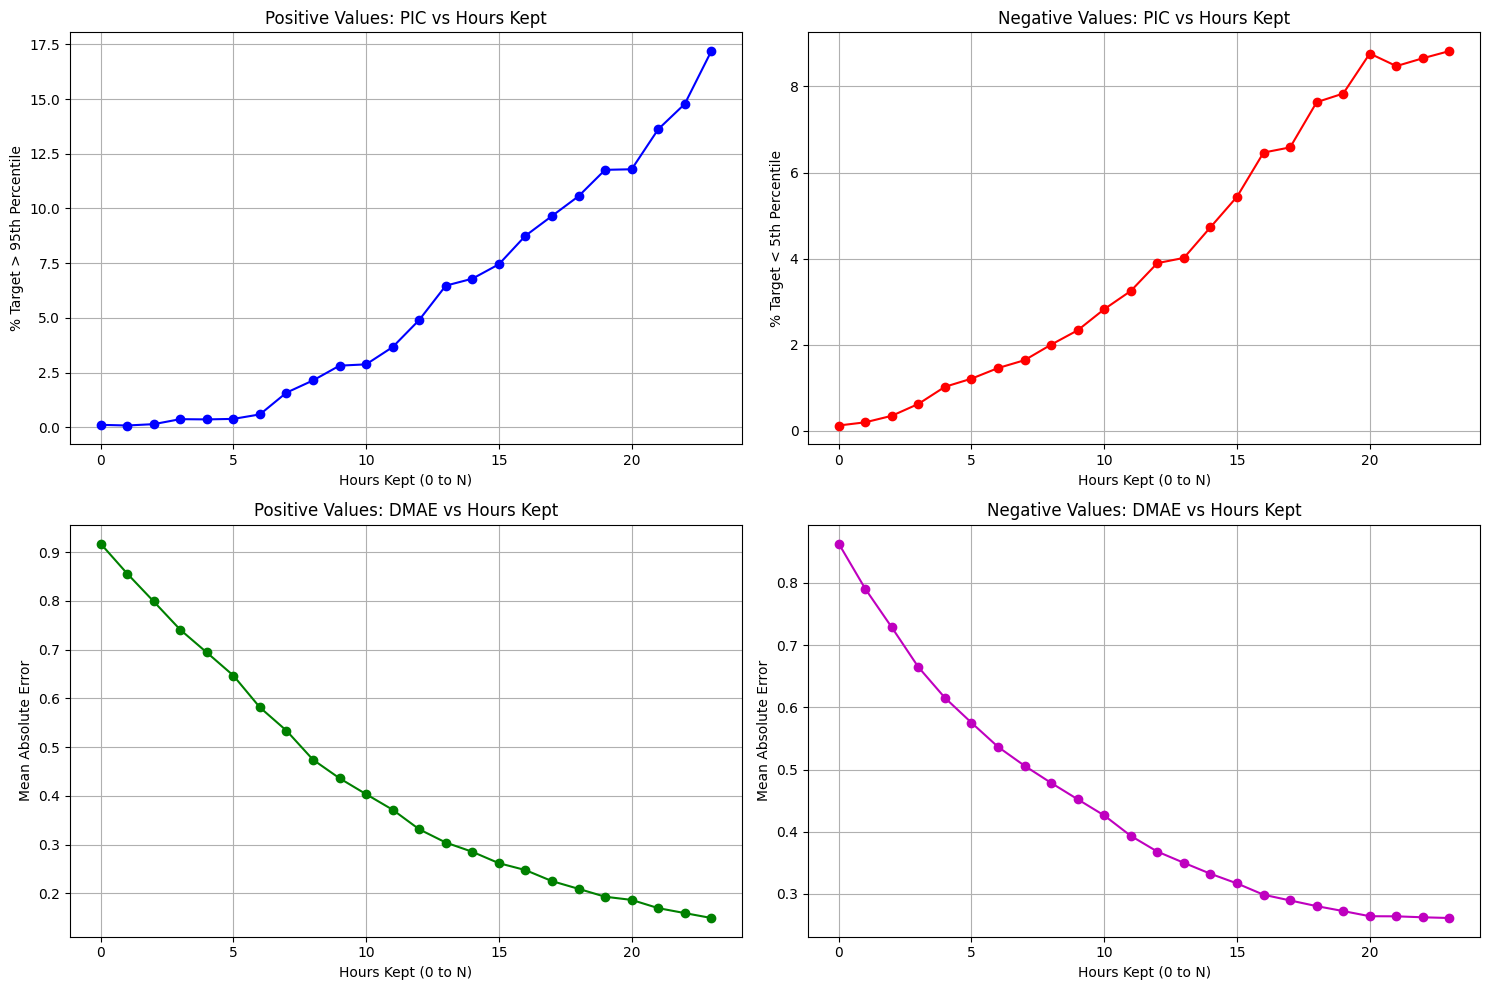

{'hours_kept': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 'positive_accuracy': [np.float64(0.11029411764705882),
  np.float64(0.07965686274509803),
  np.float64(0.14093137254901958),
  np.float64(0.36913250148544263),
  np.float64(0.35830999066293184),
  np.float64(0.3819444444444444),
  np.float64(0.5864927556104026),
  np.float64(1.5807446230240345),
  np.float64(2.139610797699033),
  np.float64(2.8151158482040834),
  np.float64(2.8743478743478743),
  np.float64(3.664696210652093),
  np.float64(4.903262211214997),
  np.float64(6.471225122057166),
  np.float64(6.788938830347498),
  np.float64(7.448104011571504),
  np.float64(8.751895464356764),
  np.float64(9.656309946073877),
  np.float64(10.560061015266124),
  np.float64(11.764542807983212),
  np.float64(11.790758422434118),
  np.float64(13.619658957313755),
  np.float64(14.777258130586304),
  np.float64(17.193530959494584)],
 'negative_accur

In [18]:
plot_masking_impact(model, val_dataset, latent_dim, 500)

In [ ]:
model1 = plot_masking_impact(model, val_dataset, latent_dim, 500)

In [ ]:
model2 = plot_masking_impact(model, val_dataset, latent_dim, 500)

In [ ]:
def plot_comparison(results1, results2, model1_name="Model 1", model2_name="Model 2"):
    hours_to_keep = results1['hours_kept']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Positive Accuracy
    ax1.plot(hours_to_keep, results1['positive_accuracy'], 'bo-', markersize=6, label=model1_name)
    ax1.plot(hours_to_keep, results2['positive_accuracy'], 'ro-', markersize=6, label=model2_name)
    ax1.set_xlabel('Hours Kept (0 to N)')
    ax1.set_ylabel('% Target > 95th Percentile')
    ax1.set_title('Positive Values: PIC vs Hours Kept')
    ax1.grid(True)
    ax1.legend()
    
    # Negative Accuracy
    ax2.plot(hours_to_keep, results1['negative_accuracy'], 'bo-', markersize=6, label=model1_name)
    ax2.plot(hours_to_keep, results2['negative_accuracy'], 'ro-', markersize=6, label=model2_name)
    ax2.set_xlabel('Hours Kept (0 to N)')
    ax2.set_ylabel('% Target < 5th Percentile')
    ax2.set_title('Negative Values: PIC vs Hours Kept')
    ax2.grid(True)
    ax2.legend()
    
    # Positive MAE
    ax3.plot(hours_to_keep, results1['positive_mae'], 'go-', markersize=6, label=model1_name)
    ax3.plot(hours_to_keep, results2['positive_mae'], 'mo-', markersize=6, label=model2_name)
    ax3.set_xlabel('Hours Kept (0 to N)')
    ax3.set_ylabel('Mean Absolute Error')
    ax3.set_title('Positive Values: DMAE vs Hours Kept')
    ax3.grid(True)
    ax3.legend()
    
    # Negative MAE
    ax4.plot(hours_to_keep, results1['negative_mae'], 'go-', markersize=6, label=model1_name)
    ax4.plot(hours_to_keep, results2['negative_mae'], 'mo-', markersize=6, label=model2_name)
    ax4.set_xlabel('Hours Kept (0 to N)')
    ax4.set_ylabel('Mean Absolute Error')
    ax4.set_title('Negative Values: DMAE vs Hours Kept')
    ax4.grid(True)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

plot_comparison(model1, model2, "Standard Model", "Enhanced Model")